In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem.wordnet import WordNetLemmatizer
import string

In [24]:
wordsToCut = set(stopwords.words('english'))
wordsToCut

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [35]:
print ('A' in wordsToCut)

False


In [3]:
#data = pd.read_csv('/Users/daviddeng8/affinity/data/outlet_data.csv')
#data['content'][:100]
data = pd.read_csv('/Users/daviddeng8/Documents/Projects/affinity/data/final_data.csv')
#data.loc[261, 'Url']
data

,Url,Author,Date,Header,Body,n_links,Source,Bias,Quality
0,https://abcnews.go.com/Politics/abortion-right...,Devin Dwyer,"Wed, 17 Apr 2019 10:14:00 GMT",Abortion rights group asks Supreme Court to st...,Abortion rights advocates have asked the U.S. ...,3.0,ABC,1.67,49.00
1,https://abcnews.go.com/Politics/appeals-court-...,Ali Dukakis,"Tue, 26 Feb 2019 09:05:00 GMT",Appeals court says special counsel Robert Muel...,A federal appeals court rejected the most dire...,2.0,ABC,0.67,51.67
2,https://abcnews.go.com/Politics/attorney-gener...,Luke Barr,"Wed, 17 Apr 2019 14:02:00 GMT",Attorney general orders some asylum seekers to...,As part of the Trump administration's effort t...,6.0,ABC,-2.75,43.50
3,https://abcnews.go.com/Politics/donald-trump-t...,Meridith McGraw,"Tue, 19 Mar 2019 12:44:00 GMT","Donald Trump and 'the Trump of the Tropics,' B...","President Donald Trump and ""the Trump of the T...",10.0,ABC,-4.33,52.67
4,https://abcnews.go.com/Politics/electoral-coll...,Matthew Dowd,"Tue, 19 Mar 2019 21:39:00 GMT",The Electoral College limits the campaign play...,"U.S Senator Elizabeth Warren, who is competing...",5.0,ABC,-10.00,32.00
...,...,...,...,...,...,...,...,...,...
1670,https://www.wnd.com/2019/04/12-french-churches...,WND Staff,"Tue, 16 Apr 2019 11:53:00 GMT",12 French churches attacked before Notre Dame ...,Only hours after the first flames that eventua...,18.0,WorldNetDaily,19.75,19.75
1671,https://www.wnd.com/2019/04/doj-sued-for-detai...,WND Staff,"Tue, 16 Apr 2019 19:16:00 GMT",DOJ sued for details of payments to Christophe...,Washington watchdog Judicial Watch believes th...,2.0,WorldNetDaily,30.50,21.25
1672,https://www.wnd.com/2019/04/fox-news-stars-pul...,WND Staff,"Tue, 16 Apr 2019 14:23:00 GMT",Fox News stars pull plug on history of church ...,"Two Fox News personalities, as Notre Dame Cath...",7.0,WorldNetDaily,29.75,12.00
1673,https://www.wnd.com/2019/04/major-u-s-bank-shu...,WND Staff,"Tue, 16 Apr 2019 16:37:00 GMT",Major U.S. bank shuts down 'alt-right' accounts,Chase Bank is shutting down accounts of people...,3.0,WorldNetDaily,22.00,25.25


In [4]:
def getPOS(words):
    #return nltk.pos_tag(word)
    return [(word, get_wordnet_pos(word)) for word in words]

In [5]:
def getIndividualPOS(word):
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV} 
    tag = nltk.pos_tag(word[0].upper())
    return tag_dict.get(tag)

In [6]:
#https://www.machinelearningplus.com/nlp/lemmatization-examples-python/

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}    
    tag = nltk.pos_tag([word])[0][1][0].upper()
    return tag_dict.get(tag, wordnet.NOUN)

In [7]:
print (getPOS(['hello', 'bye']))

[('hello', 'n'), ('bye', 'n')]


In [41]:
for index, row in data.iterrows():
    
    #removing stopwords and punctuation
    tokenized = nltk.word_tokenize(row['Body'])
    temp = [word for word in tokenized if word.lower() not in wordsToCut and word not in string.punctuation]
    
    #row['Body'] = ' '.join(temp)
    
    #row['Body'] = [word for word in nltk.word_tokenize(row['Body']) if word not in wordsToCut]
    #row['Body'] = row['Body'].lower()
    #nopunc = [char for char in row['Body'] if char not in string.punctuation]
    #nopunc.join('')
    
    #lemmatizing
    
    lemmatizer = WordNetLemmatizer()
    partsOfSpeech = getPOS(temp)
    
    #ONLY KEEPING ENTITIES
    lemmatized = [lemmatizer.lemmatize(word, pos) for word, pos in partsOfSpeech if pos == 'n']
    final = ' '.join(lemmatized)
    data.at[index, 'Body'] = final
    
    


In [42]:
data

,Url,Author,Date,Header,Body,n_links,Source,Bias,Quality
0,https://abcnews.go.com/Politics/abortion-right...,Devin Dwyer,"Wed, 17 Apr 2019 10:14:00 GMT",Abortion rights group asks Supreme Court to st...,Abortion right advocate ask U.S. Supreme Court...,3.0,ABC,1.67,49.00
1,https://abcnews.go.com/Politics/appeals-court-...,Ali Dukakis,"Tue, 26 Feb 2019 09:05:00 GMT",Appeals court says special counsel Robert Muel...,appeal court reject challenge counsel Robert M...,2.0,ABC,0.67,51.67
2,https://abcnews.go.com/Politics/attorney-gener...,Luke Barr,"Wed, 17 Apr 2019 14:02:00 GMT",Attorney general orders some asylum seekers to...,part Trump administration 's effort migrant cr...,6.0,ABC,-2.75,43.50
3,https://abcnews.go.com/Politics/donald-trump-t...,Meridith McGraw,"Tue, 19 Mar 2019 12:44:00 GMT","Donald Trump and 'the Trump of the Tropics,' B...",President Donald Trump `` Trump Tropics `` pre...,10.0,ABC,-4.33,52.67
4,https://abcnews.go.com/Politics/electoral-coll...,Matthew Dowd,"Tue, 19 Mar 2019 21:39:00 GMT",The Electoral College limits the campaign play...,U.S Senator Elizabeth Warren compete nominatio...,5.0,ABC,-10.00,32.00
...,...,...,...,...,...,...,...,...,...
1670,https://www.wnd.com/2019/04/12-french-churches...,WND Staff,"Tue, 16 Apr 2019 11:53:00 GMT",12 French churches attacked before Notre Dame ...,hour flame would consume Notre Dame 's roof sp...,18.0,WorldNetDaily,19.75,19.75
1671,https://www.wnd.com/2019/04/doj-sued-for-detai...,WND Staff,"Tue, 16 Apr 2019 19:16:00 GMT",DOJ sued for details of payments to Christophe...,Washington watchdog Watch FBI cover informatio...,2.0,WorldNetDaily,30.50,21.25
1672,https://www.wnd.com/2019/04/fox-news-stars-pul...,WND Staff,"Tue, 16 Apr 2019 14:23:00 GMT",Fox News stars pull plug on history of church ...,Two Fox News personality Notre Dame Paris engu...,7.0,WorldNetDaily,29.75,12.00
1673,https://www.wnd.com/2019/04/major-u-s-bank-shu...,WND Staff,"Tue, 16 Apr 2019 16:37:00 GMT",Major U.S. bank shuts down 'alt-right' accounts,Chase Bank shut account people organization vi...,3.0,WorldNetDaily,22.00,25.25


In [43]:
vectorizer = TfidfVectorizer(use_idf = True, stop_words = 'english')
matrix = vectorizer.fit_transform(data['Body'])
df = pd.DataFrame(matrix.toarray(), columns = vectorizer.get_feature_names())
#list comprehension
#x = np.where(df['électricité'] != 0)
df

,00,000,00028312038003499,0002831216653206,000lb,0013189,001488,002,003,004,...,égalité,électricité,élysée,élysées,émigré,état,île,øystein,𝙹𝚞𝚊𝚗,𝚁𝚘𝚍𝚛𝚒𝚐𝚞𝚎𝚣
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.069392,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1671,0.0,0.021118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1672,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1673,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
df = df.drop([columnName for (columnName, columnData) in df.iteritems() if columnName.isalpha() == False], axis=1)
df

,aa,aaa,aaf,aaliyah,aapl,aaron,aarp,aarseth,ababa,aback,...,égalité,électricité,élysée,élysées,émigré,état,île,øystein,𝙹𝚞𝚊𝚗,𝚁𝚘𝚍𝚛𝚒𝚐𝚞𝚎𝚣
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1671,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1672,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1673,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
number_of_clusters = 50
model = KMeans(n_clusters = number_of_clusters)
model.fit(matrix)

# elbow method, silhouette score
# entity recognition: do the same clustering but with only entities (nouns)

In [45]:
km_scores= []
km_silhouette = []
vmeasure_score =[]
db_score = []
for i in range(2,50):
    km = KMeans(n_clusters=i, random_state=0).fit(matrix)
    preds = km.predict(matrix)
    
    print("Score for number of cluster(s) {}: {}".format(i,km.score(matrix)))
    km_scores.append(-km.score(matrix))
    
    silhouette = silhouette_score(matrix,preds)
    km_silhouette.append(silhouette)
    print("Silhouette score for number of cluster(s) {}: {}".format(i,silhouette))
    

Score for number of cluster(s) 2: -1596.4553278945248
Silhouette score for number of cluster(s) 2: 0.005143046964424559
Score for number of cluster(s) 3: -1579.3506424684242
Silhouette score for number of cluster(s) 3: 0.0067649786490877805
Score for number of cluster(s) 4: -1567.8140577566649
Silhouette score for number of cluster(s) 4: 0.008041215100651483
Score for number of cluster(s) 5: -1556.6467113269503
Silhouette score for number of cluster(s) 5: 0.011776180627634773
Score for number of cluster(s) 6: -1547.5352515482855
Silhouette score for number of cluster(s) 6: 0.01377307088844523
Score for number of cluster(s) 7: -1540.0894638144105
Silhouette score for number of cluster(s) 7: 0.014649202339014707
Score for number of cluster(s) 8: -1537.1458379944995
Silhouette score for number of cluster(s) 8: 0.01633379738092768
Score for number of cluster(s) 9: -1529.0250563262364
Silhouette score for number of cluster(s) 9: 0.01720491041282944
Score for number of cluster(s) 10: -1526.6

KeyboardInterrupt: 

In [49]:
import matplotlib.pyplot as plt

In [51]:
len(km_scores)

42

Text(0, 0.5, 'elbow method score')

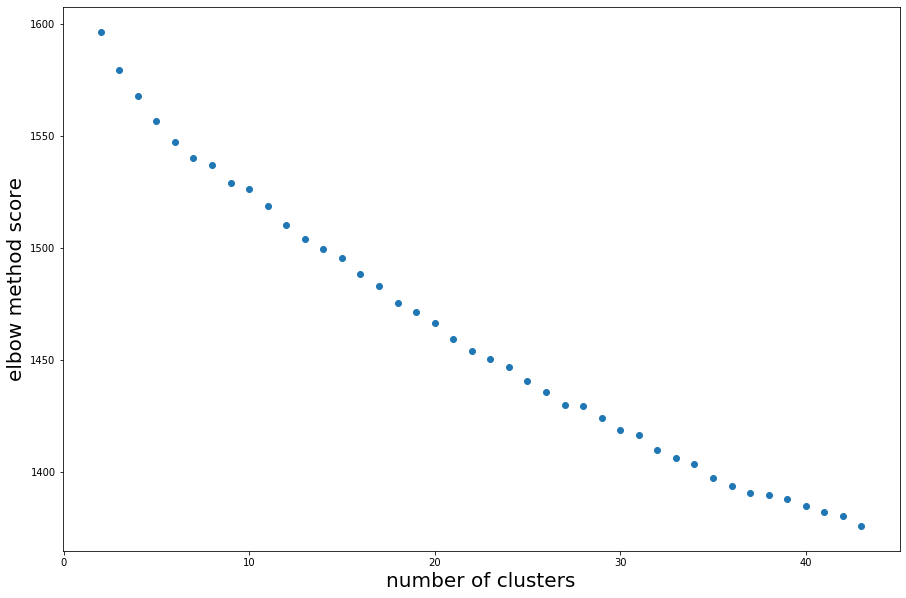

In [52]:
plt.figure(figsize = (15, 10))
plt.scatter(x = [i for i in range(2, 44)], y = km_scores)
plt.xlabel('number of clusters', fontsize=20)
plt.ylabel('elbow method score', fontsize=20)

ValueError: x and y must be the same size

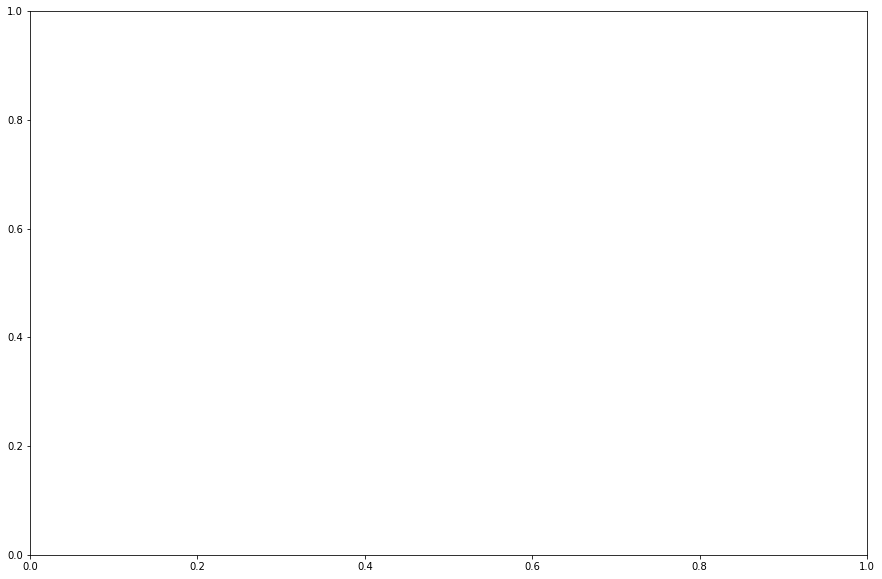

In [48]:
plt.figure(figsize = (15, 10))
plt.scatter(x = [i for i in range(2, 50)], y = km_silhouette)
plt.xlabel('number of clusters', fontsize = 20)
plt.ylabel('silhouette score', fontsize = 20)

In [ ]:
number_of_clusters = 12
model = KMeans(n_clusters = number_of_clusters)
model.fit(matrix)

In [ ]:
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(number_of_clusters):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

In [ ]:
import pandas as pd
gapminder_url='https://bit.ly/2cLzoxH'
gapminder = pd.read_csv(gapminder_url)
gapminder

In [ ]:
gapminder_ocean = gapminder[(gapminder.year > 2000) & (gapminder.continent == 'Oceania')]
gapminder_ocean

In [ ]:
new = gapminder_ocean.drop([columnName for (columnName, columnData) in gapminder_ocean.iteritems() if columnName == 'pop'], axis = 1)
new

In [ ]:
new['69'] = [0, 0, 0, 0]
new

In [ ]:
new = new.drop([columnName if ])

### OLD DATA

In [ ]:
data = pd.read_csv('/Users/daviddeng8/Documents/Projects/affinity/data/outlet_data.csv')

### Spacy Part of speech tagging